In [ ]:
"""Fundamentals of Data Analytics – HashSysTech Insurance
Machine Learning Meets Term Life Insurance: Project Greenlight"""
# Importing important libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

In [ ]:
# Load dataset
df = pd.read_csv("/content/sample_data/dataset.csv")
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (45211, 11)


,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


In [ ]:
# Task 1.1 Data Exploration
# Identify numerical and categorical columns
numeric_features = ["age", "day", "dur", "num_calls"]
categorical_features = ["job", "marital", "education_qual",
                        "call_type", "mon", "prev_outcome", "y"]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['age', 'day', 'dur', 'num_calls']
Categorical features: ['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome', 'y']


In [ ]:
# Descriptive statistics for numerical features
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [ ]:
# Frequency tables for categorical features
for col in categorical_features:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())



Value counts for job:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

Value counts for marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Value counts for education_qual:
education_qual
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Value counts for call_type:
call_type
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

Value counts for mon:
mon
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

Value counts for prev_outcome:
prev_outcome
unknown    36959
failure     4901
other  

In [ ]:
# Task 1.2: Missing Values and Outliers
# 1. Missing values
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64


In [ ]:
# 2. Outlier detection using the IQR rule for numeric features

def iqr_outlier_mask(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

outlier_counts = {}
for col in numeric_features:
    mask = iqr_outlier_mask(df[col])
    outlier_counts[col] = mask.sum()

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient="index",
                                    columns=["num_outliers"])
outlier_df


,num_outliers
age,487
day,0
dur,3235
num_calls,3064


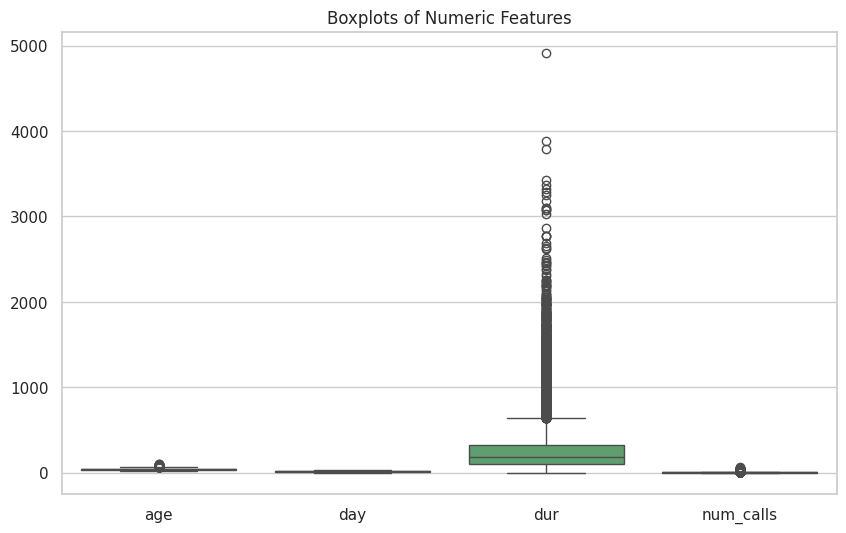

In [ ]:
# Visualization of outliers using boxplots

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_features])
plt.title("Boxplots of Numeric Features")
plt.show()


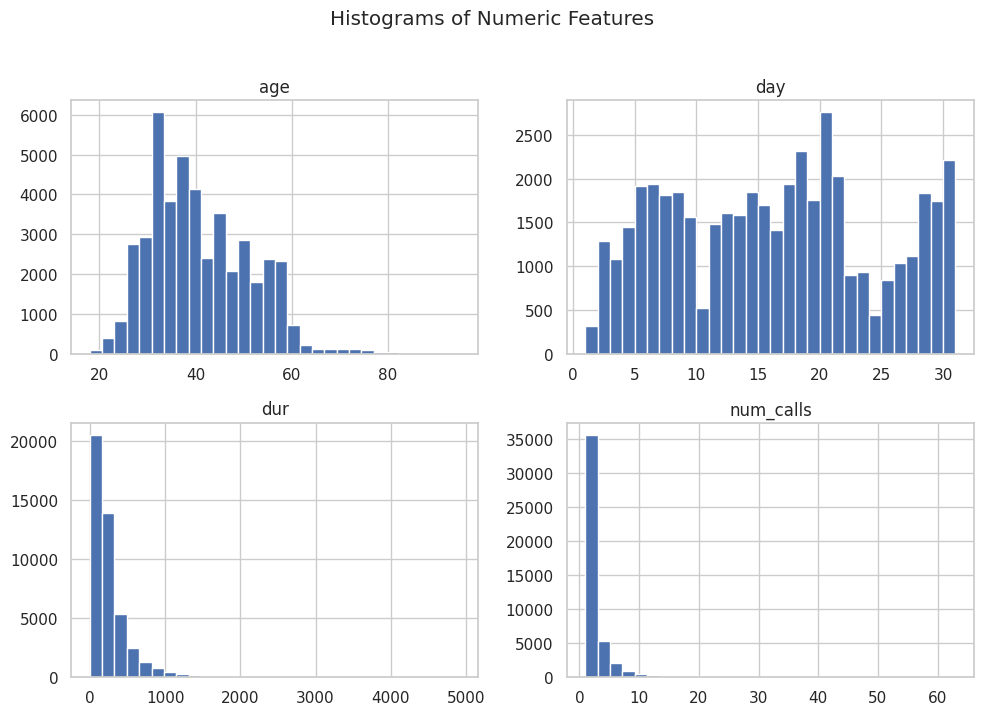

In [ ]:
# Task 1.3: Data visualization
# 1. Histograms for numerical variables
df[numeric_features].hist(bins=30, figsize=(10, 7))
plt.suptitle("Histograms of Numeric Features", y=1.02)
plt.tight_layout()
plt.show()

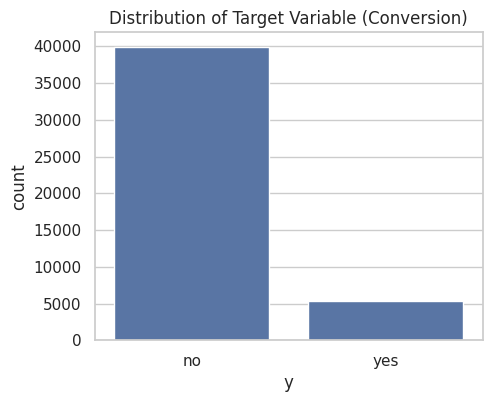

In [ ]:
# 2. Target distribution (class balance)
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="y")
plt.title("Distribution of Target Variable (Conversion)")
plt.show()

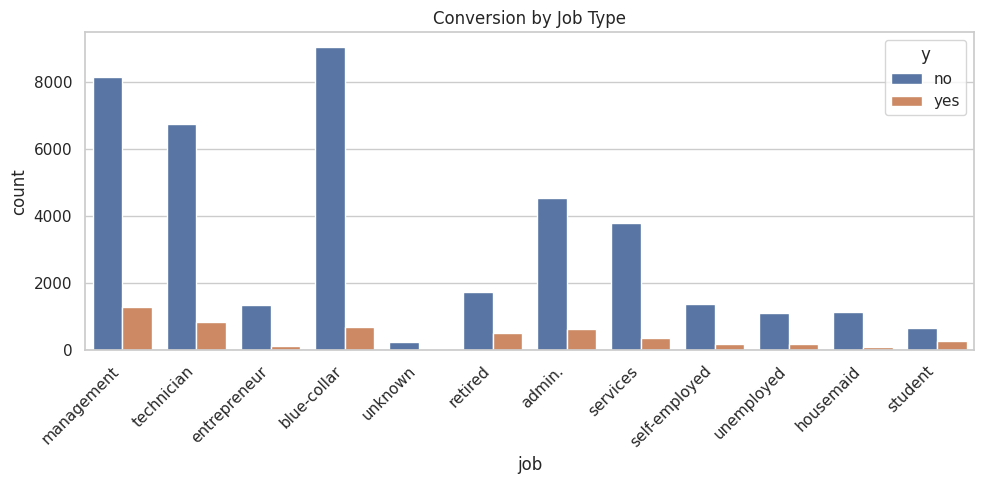

In [ ]:
# 3. Conversion rate by job type
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="job", hue="y")
plt.xticks(rotation=45, ha="right")
plt.title("Conversion by Job Type")
plt.tight_layout()
plt.show()


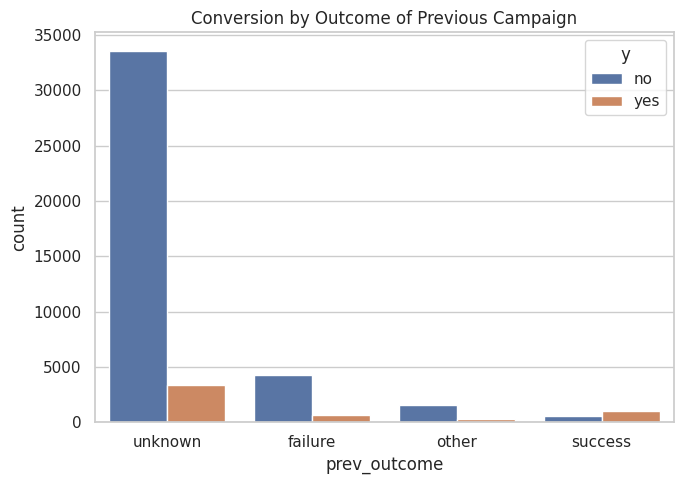

In [ ]:
# 4. Conversion rate by previous outcome
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="prev_outcome", hue="y")
plt.title("Conversion by Outcome of Previous Campaign")
plt.tight_layout()
plt.show()


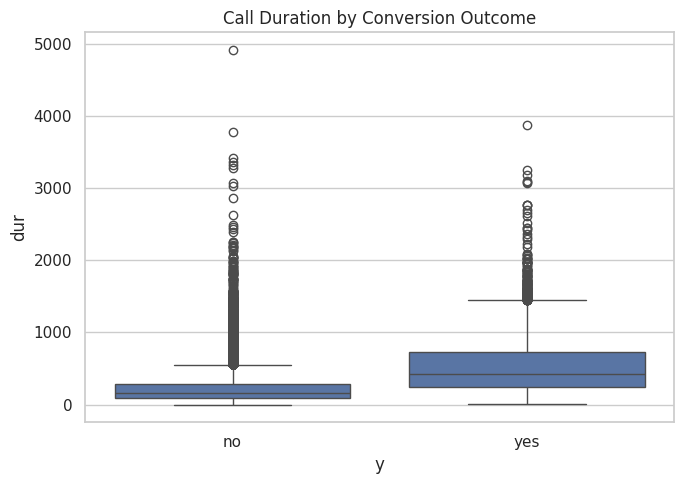

In [ ]:
# 5) Relationship between call duration and conversion
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="y", y="dur")
plt.title("Call Duration by Conversion Outcome")
plt.tight_layout()
plt.show()


In [ ]:
# Task 2.1: Model selection (logistic regression & random forest)
# We define feature matrix X and target y
X = df.drop(columns=["y"])
y = df["y"]

# Reconfirm our numeric & categorical feature lists, excluding target
numeric_features = ["age", "day", "dur", "num_calls"]
categorical_features = ["job", "marital", "education_qual",
                        "call_type", "mon", "prev_outcome"]

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())

X shape: (45211, 10)
Target distribution:
 y
no     39922
yes     5289
Name: count, dtype: int64


In [ ]:
# Task 2.2: Preprocessing and  stratified Train/Test split

# Preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Stratified split to preserve y distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))



Train shape: (36168, 10)
Test shape: (9043, 10)
Train target distribution:
 y
no     0.883018
yes    0.116982
Name: proportion, dtype: float64
Test target distribution:
 y
no     0.883003
yes    0.116997
Name: proportion, dtype: float64


In [ ]:
# Train baseline models: Logistic Regression & Random Forest

# Logistic Regression pipeline
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"  # helps with class imbalance
    ))
])

# Fit both models
log_reg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

print("Models trained successfully.")


Models trained successfully.


In [ ]:
# Function to evaluate classification models

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label="yes")
    rec = recall_score(y_test, y_pred, pos_label="yes")
    f1 = f1_score(y_test, y_pred, pos_label="yes")

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["no", "yes"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["no", "yes"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

    # ROC curve if probabilities available
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test.map({"no": 0, "yes": 1}), y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {name}")
        plt.legend()
        plt.show()

    return {"model": name, "accuracy": acc, "precision": prec,
            "recall": rec, "f1": f1}



=== Logistic Regression ===
Accuracy : 0.9003
Precision: 0.6429
Recall   : 0.3318
F1-score : 0.4377

Classification report:
              precision    recall  f1-score   support

          no       0.92      0.98      0.95      7985
         yes       0.64      0.33      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



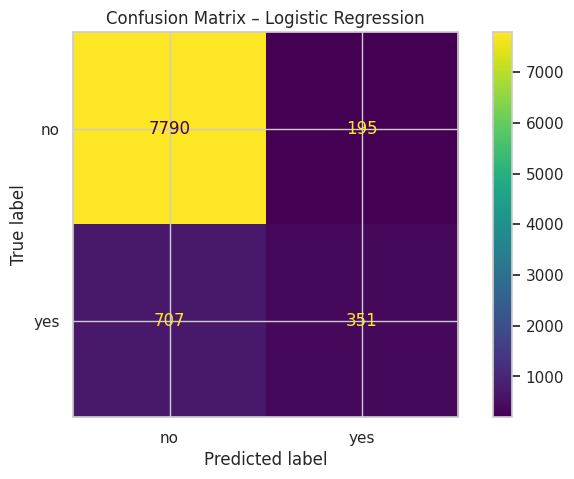

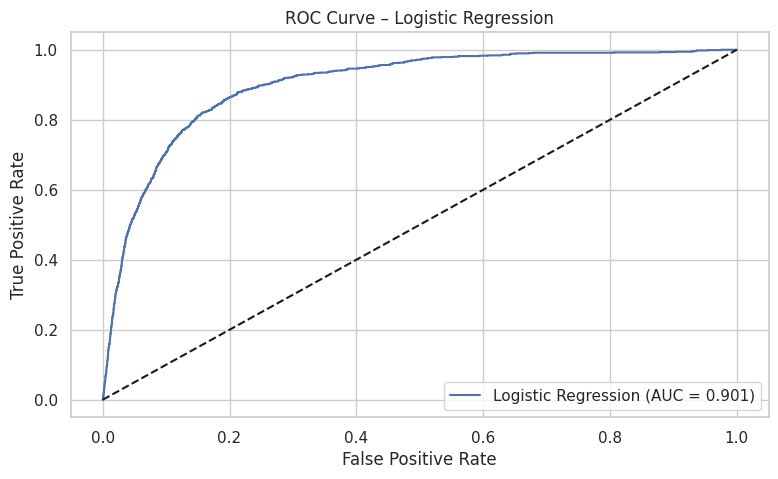


=== Random Forest ===
Accuracy : 0.9021
Precision: 0.6531
Recall   : 0.3488
F1-score : 0.4547

Classification report:
              precision    recall  f1-score   support

          no       0.92      0.98      0.95      7985
         yes       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



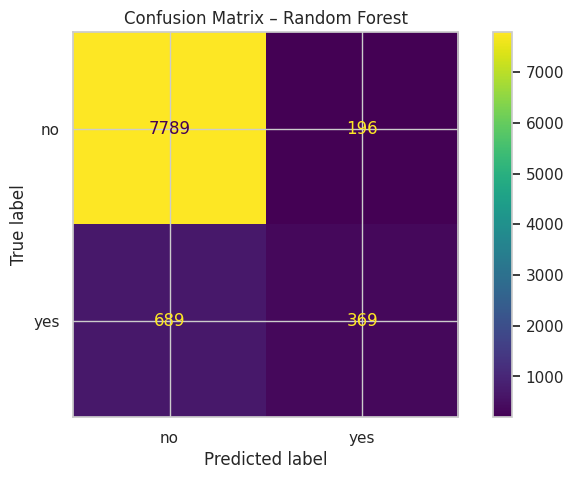

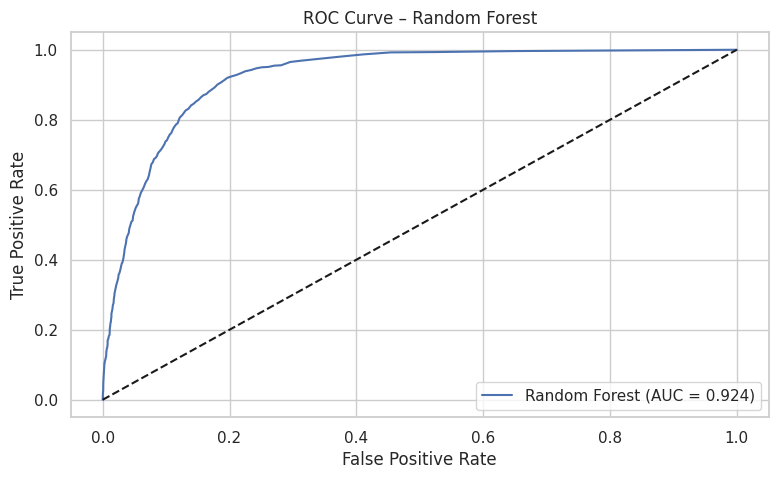

,model,accuracy,precision,recall,f1
0,Logistic Regression,0.900254,0.642857,0.331758,0.437656
1,Random Forest,0.902134,0.653097,0.348771,0.454713


In [ ]:
# Task 3.2 – Baseline model evaluation

results = []
results.append(evaluate_model("Logistic Regression", log_reg_clf, X_test, y_test))
results.append(evaluate_model("Random Forest", rf_clf, X_test, y_test))

results_df = pd.DataFrame(results)
results_df


In [ ]:
# Task 3.1 – Model Interpretation
# Feature importance from best performing model (Random Forest)

# Get the fitted RandomForest step from the pipeline
rf_model = rf_clf.named_steps["model"]

# Get feature names after preprocessing
feature_names = rf_clf.named_steps["preprocess"].get_feature_names_out()

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Show top 15 features
top15 = feat_imp.head(15)
top15


,feature,importance
2,num__dur,0.380917
0,num__age,0.101512
1,num__day,0.094300
40,cat__prev_outcome_success,0.045511
3,num__num_calls,0.043534
25,cat__call_type_unknown,0.028353
41,cat__prev_outcome_unknown,0.022795
23,cat__call_type_cellular,0.017892
34,cat__mon_may,0.016663
33,cat__mon_mar,0.013461


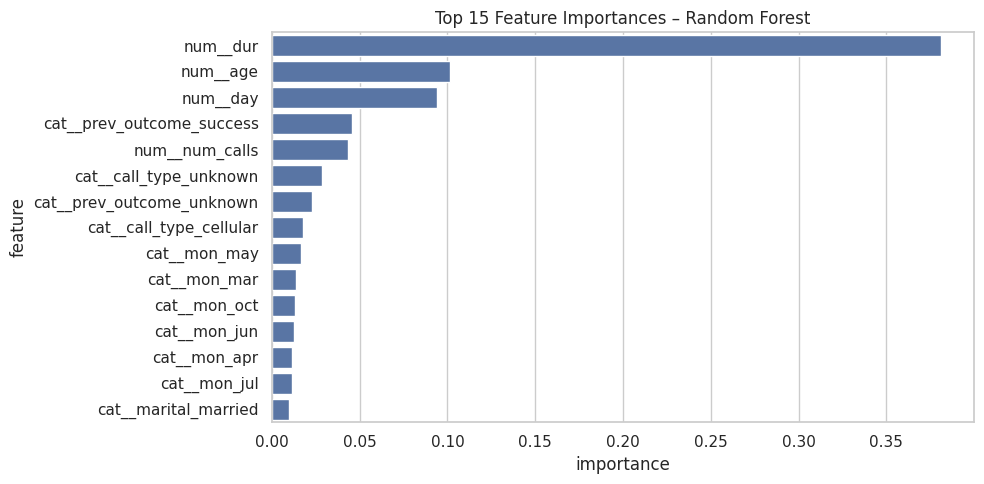

In [ ]:
# Barplot of top 15 important features
plt.figure(figsize=(10, 5))
sns.barplot(data=top15, x="importance", y="feature")
plt.title("Top 15 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import make_scorer, f1_score

# Define scorer that explicitly sets the positive class
f1_scorer = make_scorer(f1_score, pos_label="yes")

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20],
    "model__min_samples_split": [5],
    "model__min_samples_leaf": [2]
}

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV F1-score: 0.6071694765272108



=== Tuned Random Forest ===
Accuracy : 0.8854
Precision: 0.5072
Recall   : 0.7363
F1-score : 0.6006

Classification report:
              precision    recall  f1-score   support

          no       0.96      0.91      0.93      7985
         yes       0.51      0.74      0.60      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.82      0.77      9043
weighted avg       0.91      0.89      0.89      9043



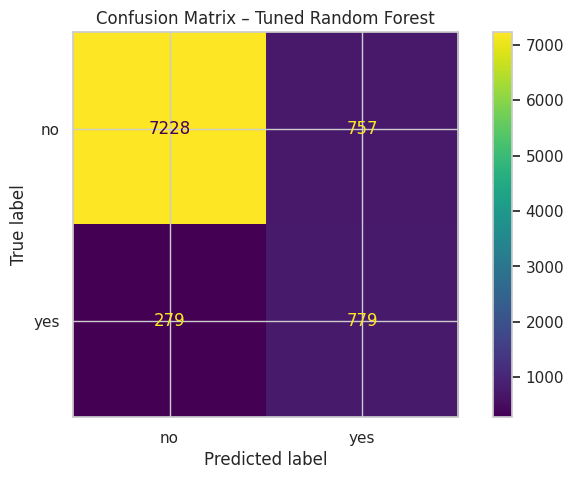

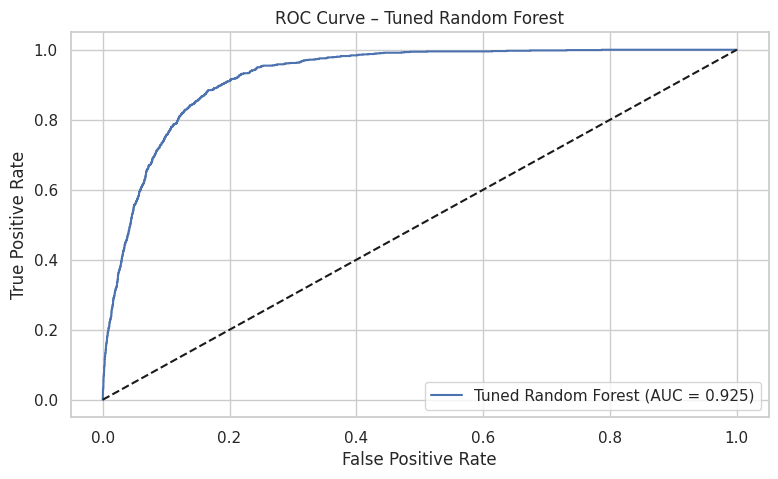

{'model': 'Tuned Random Forest',
 'accuracy': 0.8854362490324007,
 'precision': 0.5071614583333334,
 'recall': 0.7362948960302458,
 'f1': 0.6006168080185043}

In [ ]:
# Evaluate tuned model on the test set
best_rf = grid_search.best_estimator_
tuned_result = evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)
tuned_result
